# Flexible Ligand - Flexible Protein Docking

# Theory: 

## Introduction
- Flexible ligand-flexible protein docking models the interaction between a ligand (e.g., drug candidate) and a protein receptor, allowing for conformational changes in both molecules.
- It is particularly useful for studying complex binding mechanisms, such as induced fit or allosteric modulation, where structural flexibility is key.

## Key Concepts
- **Molecular Flexibility**:
  - Proteins are not rigid; they undergo conformational changes to optimize interactions with ligands (induced fit hypothesis).
  - Ligands, especially small molecules, can explore numerous conformations due to bond rotations, allowing better complementarity to the protein binding site.
    
- **Degrees of Freedom**:
  - Flexible docking involves sampling multiple torsional angles for the ligand and accounting for side-chain and/or backbone movements in the protein.
  - While this adds complexity, it significantly improves docking accuracy.

## Simulation Workflow
1. **Ligand Preparation**:
   - Ligand flexibility is introduced by allowing bond rotations and conformational sampling.
   - Rotatable bonds and dihedral angles are defined for dynamic adjustments during docking.
2. **Protein Preparation**:
   - Define the side-chain flexibility: Commonly used for residues near the binding site.
4. **Search Algorithm**:
   - Algorithms such as Monte Carlo, Genetic Algorithms, or Molecular Dynamics are used to explore the conformational space of both the ligand and the protein.
   - Scoring functions evaluate binding affinity for each sampled conformation.
5. **Result Evaluation**:
   - Docking results typically consist of clusters of conformations ranked by predicted binding affinity and stability.
   - Analysis often includes identifying the most plausible binding mode and key molecular interactions (e.g., hydrogen bonds, hydrophobic contacts).


# Practice

1. **Implement flexible-protein / flexible-ligand docking with GNINA**

2. **Fetching of PDB files (see T015)**

3. **Preparation of protein using PDBFixer (develop on your own)**

4. **Selection of binding site (see T015)** 

5. **Selection of flexible residues (develop on your own, see GNINA documentation)** 

6. **Preparation of ligand (see T015)** 

7. **Docking into selected binding site (similar to T015 but check additional parameters)** 

8. **Calculation of RMSD relative to crystal ligand (develop on your own)** 

9. **Tools for comparing results** 

10. **RMSD between rigid and flexible ligand poses (develop on your own)** 

11. **Comparison of position/coordinates of protein residues (develop on your own)** 

In [1]:
# import libraries
import warnings
from pathlib import Path
import subprocess
import urllib

import requests
from pathlib import Path

from pdbfixer import PDBFixer
from openmm.app import PDBFile
import os

import nglview as nv
from openbabel import pybel
import torch

from opencadd.structure.core import Structure

# filter warnings
warnings.filterwarnings("ignore")
ob_log_handler = pybel.ob.OBMessageHandler()
pybel.ob.obErrorLog.SetOutputLevel(0)

# define paths
HERE = Path(_dh[-1])
DATA = HERE / "data"

## Fetch PDB files

In [2]:
pdb_ids = ["4IAQ", "6G79"]
Path("pdb_files").mkdir(exist_ok=True)

# Download PDB files
for pdb_id in pdb_ids:
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    with open(f"pdb_files/{pdb_id}.pdb", "wb") as file:
        file.write(response.content)
    print(f"PDB file {pdb_id} downloaded.")

PDB file 4IAQ downloaded.
PDB file 6G79 downloaded.


## Prepare the protein using PDBFixer

In [4]:
from pdbfixer import PDBFixer
from openmm.app import PDBFile
from openmm import Platform


def prepare_protein(input_pdb, output_pdb):
    platform = Platform.getPlatformByName('CPU').setPropertyDefaultValue('Threads', '4')
    fixer = PDBFixer(filename=input_pdb)
    fixer.findMissingResidues()
    fixer.findMissingAtoms()
    fixer.addMissingAtoms()
    fixer.addMissingHydrogens(7.4)  
    PDBFile.writeFile(fixer.topology, fixer.positions, open(output_pdb, 'w'))
    print(f"Protein {input_pdb} prepared and saved as {output_pdb}")


for pdb_id in pdb_ids:
    prepare_protein(f"pdb_files/{pdb_id}.pdb", f"pdb_files/{pdb_id}_prepared.pdb")


Protein pdb_files/4IAQ.pdb prepared and saved as pdb_files/4IAQ_prepared.pdb
Protein pdb_files/6G79.pdb prepared and saved as pdb_files/6G79_prepared.pdb


## Select the binding site

In [3]:
from MDAnalysis import Universe

def get_binding_site(input_pdb, ligand_resname):
    # Load protein structure
    structure = Universe(input_pdb)
    
    # Select the ligand by residue name
    ligand = structure.select_atoms(f"resname {ligand_resname}")
    
    # Calculate the center of the binding pocket
    pocket_center = (ligand.positions.max(axis=0) + ligand.positions.min(axis=0)) / 2
    
    # Calculate the size of the box, adding a 5 Å buffer
    pocket_size = ligand.positions.max(axis=0) - ligand.positions.min(axis=0) + 5
    
    return pocket_center, pocket_size

# Example for 4IAQ with ligand 2GM
binding_sites = {}
ligand_resnames = {"4IAQ": "2GM", "6G79": "EP5"}

for pdb_id in ligand_resnames:
    center, size = get_binding_site(f"pdb_files/{pdb_id}_prepared.pdb", ligand_resnames[pdb_id])
    binding_sites[pdb_id] = {"center": center, "size": size}
    print(f"Binding site for {pdb_id}: Center={center}, Size={size}")


Binding site for 4IAQ: Center=[-19.9065   9.4585  22.191 ], Size=[14.856999 19.883    14.686001]
Binding site for 6G79: Center=[94.50549 52.4565  64.274  ], Size=[14.640999  22.123001  10.7979965]


## Select flexible residues

## Prepare the Ligand

In [40]:
from MDAnalysis import Universe

# File paths
prepared_4IAQ = "pdb_files/4IAQ_prepared.pdb"
prepared_6G79 = "pdb_files/6G79_prepared.pdb"
ligand_2GM = "pdb_files/2GM.pdb"
ligand_2GM_sdf = "pdb_files/2GM.sdf"

def extract_ligand(protein_pdb, ligand_resname, output_pdb):
    u = Universe(protein_pdb)  # Load the prepared protein
    ligand = u.select_atoms(f"resname {ligand_resname}")  # Select ligand by residue name
    if len(ligand) == 0:
        raise ValueError(f"Ligand {ligand_resname} not found in {protein_pdb}")
    ligand.write(output_pdb)  # Save the ligand to a PDB file
    print(f"Ligand {ligand_resname} saved to {output_pdb}")

# Correctly use the variable names
extract_ligand(prepared_4IAQ, "2GM", "pdb_files/2GM_extracted.pdb")
extract_ligand(prepared_6G79, "EP5", "pdb_files/EP5_extracted.pdb")


Ligand 2GM saved to pdb_files/2GM_extracted.pdb
Ligand EP5 saved to pdb_files/EP5_extracted.pdb


In [41]:
!obabel pdb_files/EP5_extracted.pdb -O pdb_files/EP5_cleaned.pdb


1 molecule converted


In [42]:
!obabel pdb_files/2GM_extracted.pdb -O pdb_files/2GM_cleaned.pdb


1 molecule converted


In [43]:
from rdkit import Chem
from rdkit.Chem import AllChem

def prepare_ligand(input_pdb, output_sdf):
    
    mol = Chem.MolFromPDBFile(input_pdb, removeHs=False)
    if mol is None:
        raise ValueError(f"Error reading the ligand file: {input_pdb}")
    
    
    mol_with_h = Chem.AddHs(mol)
    
   
    AllChem.EmbedMolecule(mol_with_h, AllChem.ETKDG())
    
    
    Chem.MolToMolFile(mol_with_h, output_sdf)
    print(f"Ligand with hydrogens saved as {output_sdf}")


prepare_ligand("pdb_files/2GM_cleaned.pdb", "pdb_files/2GM_with_h.sdf")
prepare_ligand("pdb_files/EP5_cleaned.pdb", "pdb_files/EP5_with_h.sdf")


Ligand with hydrogens saved as pdb_files/2GM_with_h.sdf
Ligand with hydrogens saved as pdb_files/EP5_with_h.sdf


In [ ]:
def prepare_ligand_from_smiles(smiles, output_sdf):
    try:
        mol = Chem.MolFromSmiles(smiles)  # Parse SMILES
        if mol is None:
            raise ValueError("Invalid SMILES string.")
        mol = Chem.AddHs(mol)  # Add explicit hydrogens
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())  # Generate 3D coordinates
        Chem.MolToMolFile(mol, output_sdf)  # Save to SDF
        print(f"Ligand saved to: {output_sdf}")
    except Exception as e:
        print(f"Error during ligand preparation: {e}")

# SMILES string
smiles = "C[C@@]1(C(=O)N2[C@H](C(=O)N3CCC[C@H]3[C@@]2(O1)O)Cc4ccccc4)NC(=O)[C@@H]5C[C@@H]6c7cccc8c7c(c[nH]8)C[C@H]6N(C5)C"

# Prepare ligand
prepare_ligand_from_smiles(smiles, "2GM.sdf")

In [ ]:
def prepare_ligand_from_smiles(smiles, output_sdf):
    try:
        mol = Chem.MolFromSmiles(smiles)  # Parse SMILES
        if mol is None:
            raise ValueError("Invalid SMILES string.")
        mol = Chem.AddHs(mol)  # Add explicit hydrogens
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())  # Generate 3D coordinates
        Chem.MolToMolFile(mol, output_sdf)  # Save to SDF
        print(f"Ligand saved to: {output_sdf}")
    except Exception as e:
        print(f"Error during ligand preparation: {e}")

# SMILES string
smiles = "c1cc(ccc1C#N)N2CCN(CC2)C(=O)COc3ccc4c(c3)c(c[nH]4)CC[NH3+]"

# Prepare ligand
prepare_ligand_from_smiles(smiles, "EP5.sdf")

## Docking into selected binding site

In [1]:
### 4IAQ + 2GM ###
        
!docker run -v /home/bubbles/miniconda3/CADD_Sem/pdb_files:/scr gnina/gnina gnina \
      -r /scr/4IAQ_prepared.pdb \
      -l /scr/2GM_cleaned.pdb \
      --autobox_ligand /scr/2GM_cleaned.pdb \
      --seed 123 \
      -o docking_output_4IAQ.sdf \
      --flexdist 4 \
      --flexdist_ligand /scr/2GM_cleaned.pdb \
      --out_flex flexout_4IAQ.pdb \
      --exhaustiveness 4


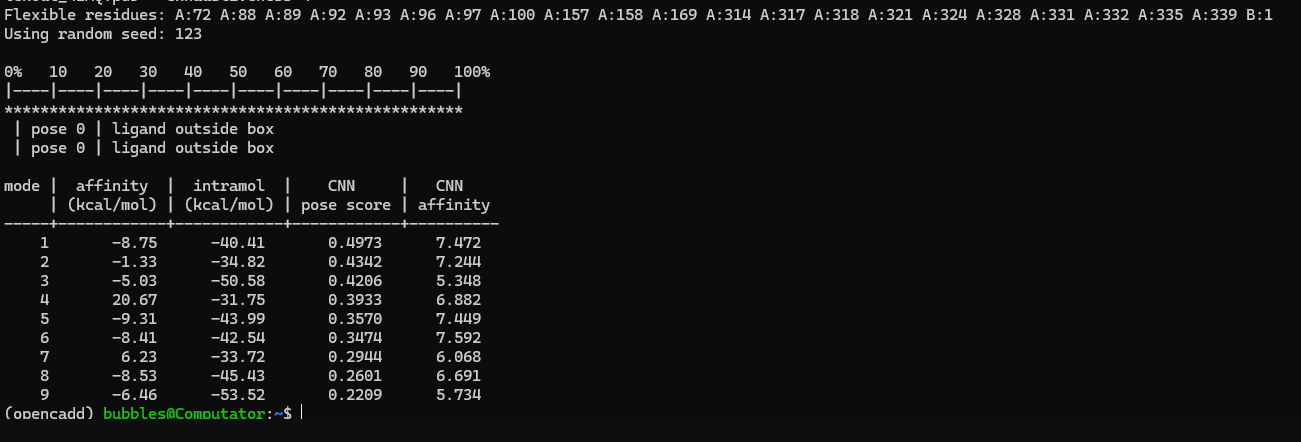

In [ ]:
### 6G79 + EP5 ###

! docker run -v /home/bubbles/miniconda3/CADD_Sem/pdb_files:/scr gnina/gnina gnina \
      -r /scr/6G79_prepared.pdb \
      -l /scr/EP5_cleaned.pdb \
      --autobox_ligand /scr/EP5_cleaned.pdb \
      --seed 123 \
      -o docking_output_6G79.sdf \
      --flexdist 4 \
      --flexdist_ligand /scr/EP5_cleaned.pdb \
      --out_flex flexout_6G79.pdb \
      --exhaustiveness 4

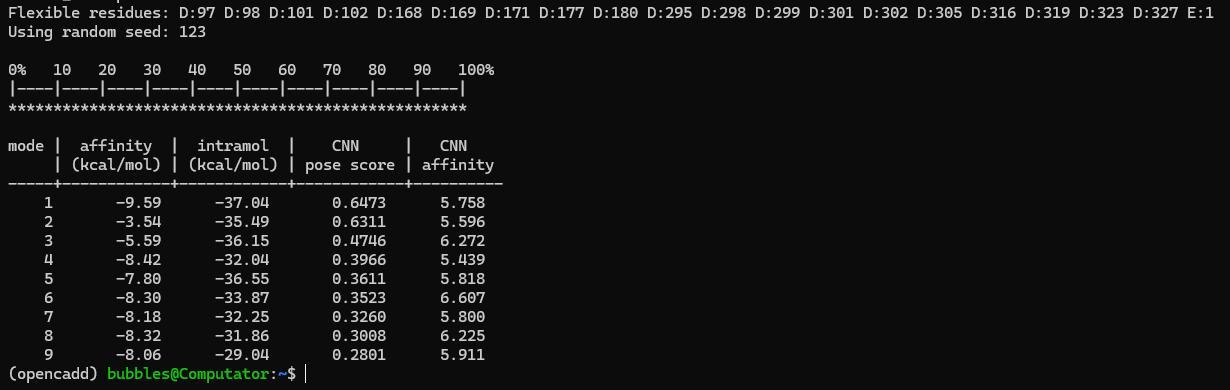

In [ ]:
## IF GNINA IS INSTALLED
# !gnina -r pdb_files/4IAQ_prepared.pdb -l pdb_files/2GM_cleaned.sdf \
#       --autobox_ligand pdb_files/2GM_cleaned.sdf \
#       --center_x -20.423 --center_y  9.5485 --center_z  9.5485 \
#       --size_x 13.526001 --size_y 17.893  --size_z 12.653  \
#       -o docking_output_4IAQ.sdf --exhaustiveness 8

## Compare results